# **Cluster**

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster


## Inputs

* outputs/datasets/collection/airplane_performance_study.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Load Data

We will drop the categorical variables Engine_Type, Multi_Engine and TPmods in order to have a pure numerical continuous data set. OR NOT! CHECK THIS LATER!!!!!

We are here dropping:
Model, Company because these are only meta data, identifiers
THR and SHP both because they are difficult to intepret
Hmax_(One) and ROC_(One) becasue since they ONLY apply to the Airplanes with a "True" under the "Multi Engine"-feature and it would therefore skew the result. Fact is I first ran this including these two variabels and indeed Hmax_(One) did come out on top as the most important feature (The second most important feature was AUW and ROC_(One) was not even there!).
Give also reason why I drop Multi_Engine and Engine Type (becasue I plan to test these without reduction)

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv")
      .drop(['Model', 'Company', 'Multi_Engine', 'Engine_Type', 'THR', 'SHP', 'Hmax_(One)', 'ROC_(One)'], axis=1)
      )
print(df.shape)
df.head(3)


(857, 17)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317


# Cluster Pipeline with all data

##  ML Cluster Pipeline

In [5]:
print(df.dtypes)

Wing_Span    float64
Length       float64
Height       float64
TP_mods         bool
AUW          float64
MEW          float64
FW           float64
Vmax         float64
Vcruise      float64
Vstall       float64
Range        float64
Hmax         float64
ROC          float64
Vlo          float64
Slo          float64
Vl           float64
Sl           float64
dtype: object


Explain why I have not the Multi_Engine and Engine_Type (cause I dropped them earlier)

In [6]:
# Convert boolean columns to strings
#df['Multi_Engine'] = df['Multi_Engine'].replace({True: 'Yes', False: 'No'})
df['TP_mods'] = df['TP_mods'].replace({True: 'Yes', False: 'No'})

# Convert integer columns to strings (if they represent categories)
#df['Engine_Type'] = df['Engine_Type'].astype(str)

# Check the updated data types
print(df.dtypes)


Wing_Span    float64
Length       float64
Height       float64
TP_mods       object
AUW          float64
MEW          float64
FW           float64
Vmax         float64
Vcruise      float64
Vstall       float64
Range        float64
Hmax         float64
ROC          float64
Vlo          float64
Slo          float64
Vl           float64
Sl           float64
dtype: object


We will use K-means since this model is ideal for numerical continuous data. For this sake we drop the three categorical features in order to not have to have a mixed data set requiring another model such as K-modes or K-prototypes.

The Threshold is set to 0.6 which is a very low value (values are typically 0.85 - 0.9) which is first of all since our values are relatively normally distributed and we shall see that even this low threshold retains only two features!

n_components=6 must be between 0 and min(n_samples, n_features)=2

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# ML algorithm
from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=50, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


## Principal Component Analysis (PCA)

In [8]:
df.head(10)

,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317
3,35.000000,21.416667,8.583333,No,1300.0,800.0,127.3,88.0,78.0,37.0,210.0,13000.0,620.0,500.0,407.797297,850.0,642.046166
4,35.000000,21.416667,8.750000,No,1220.0,740.0,93.8,83.0,74.0,33.0,175.0,12500.0,370.0,632.0,297.056192,885.0,329.571813
5,36.083333,20.333333,8.750000,No,1250.0,786.0,100.5,78.0,72.0,33.0,180.0,11000.0,360.0,583.0,393.226454,880.0,542.445142
6,36.666667,34.833333,12.083333,No,6315.0,4275.0,1105.5,264.0,230.0,80.0,868.0,25000.0,1820.0,3080.0,1950.000000,2100.0,1425.000000
7,36.583333,34.750000,12.083333,No,6000.0,4125.0,1105.5,262.0,247.0,77.0,1020.0,28000.0,1755.0,2250.0,1800.000000,2076.0,1217.000000
8,36.666667,34.833333,12.083333,No,6000.0,4056.0,1105.5,257.0,235.0,77.0,1101.0,25000.0,1460.0,2490.0,1900.000000,2030.0,1230.000000
9,36.666667,34.833333,12.083333,No,6000.0,3958.0,1105.5,257.0,237.0,77.0,1174.0,30000.0,1460.0,2490.0,1900.000000,2030.0,1230.000000


The following also does reduce dimensions since the xxxxx also uses "SmartCorrelatedSelection" and reduces the number of rows (dimensionality reduction) depending on what threshold value we set! https://feature-engine.trainindata.com/en/latest/user_guide/selection/SmartCorrelatedSelection.html Check if we can change the threshold value!

We are not concerned with the warnings below.

Since we shall find we recieve only 2 components I have only one meaningful direction of variance in my data. Selecting only one component here makes the clustering task meaningless since it would cluster the data into only one singe cluster! i.e. there are NO clusters in the dataset! By the way: Since the components is 0% and 100% we can not use the elbow method which states that we should select a number of components that has its elbow around a variance of 80%.
Choosing Components: If you have only two components (you do not have any gradual drop-off) and they are 0% and 100% of the variance, you essentially have only one meaningful direction of variance in your data. In this case, you would select 1 component since it captures all the variance available.

Elbow Method: The "elbow method" is typically used to visualize explained variance to determine the number of components. In your scenario, since you only have two components, this method is less applicable because there is no gradual drop-off in explained variance.

Perhaps considering other dimensionality reduction techniques (like t-SNE or UMAP)

In [9]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(857, 2) 
 <class 'numpy.ndarray'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Apply PCA separately to the scaled data

In [10]:
print(df_pca[:10])

[[-0.27190961 -0.5019635 ]
 [-0.27190961 -0.54756968]
 [-0.27190961 -0.55082727]
 [-0.27190961 -0.55082727]
 [-0.27190961 -0.5560394 ]
 [-0.27190961 -0.55408485]
 [-0.27190961 -0.22409155]
 [-0.27190961 -0.24461433]
 [-0.27190961 -0.24461433]
 [-0.27190961 -0.24461433]]


* The 2 components explain 100.0% of the data 



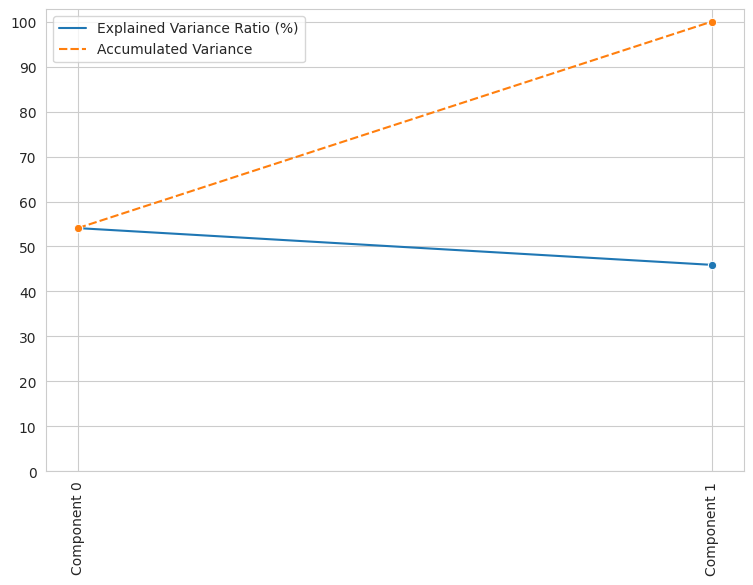

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 2 # Adapted this to two since this value cannot be higher than 
# the number of retained columns in the df_pca which was only three with a 
# threshold value as low as 0,6


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 2 components explain 100.0% of the data 



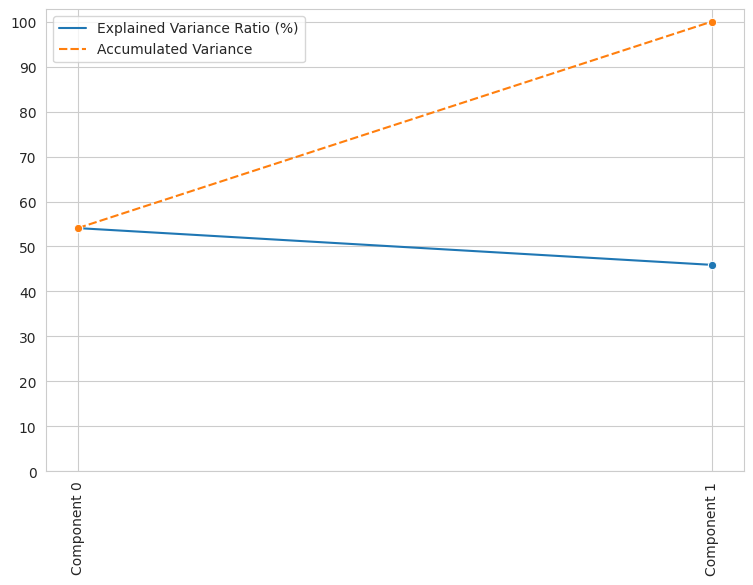

In [12]:
pca_components_analysis(df_pca=df_pca,n_components=2)

In [13]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        # we update n_components to 2
        ("PCA", PCA(n_components=2, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=2, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

## Elbow Method and Silhouette Score

In [14]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(857, 2) 
 <class 'numpy.ndarray'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


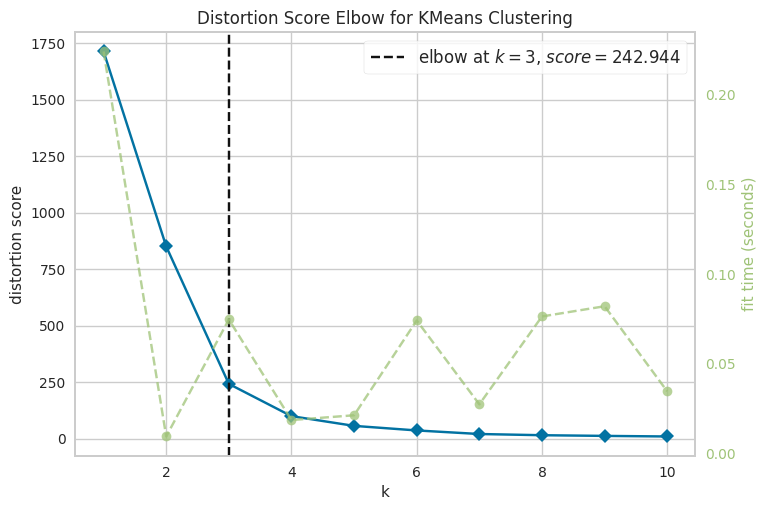

In [15]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


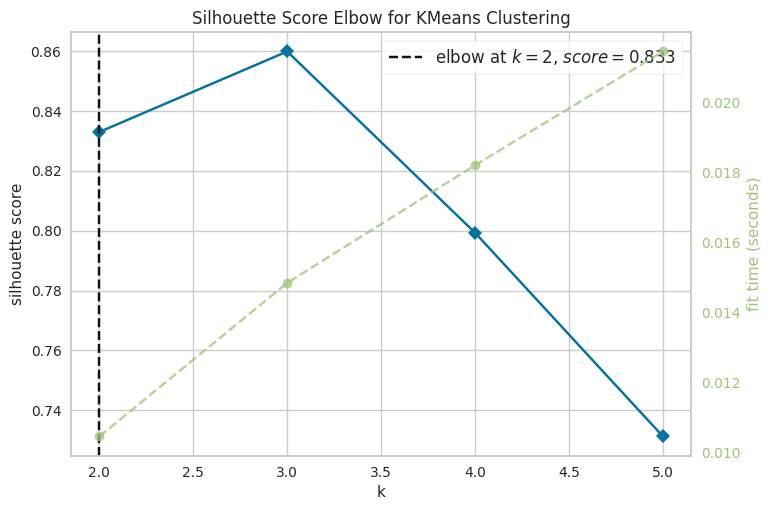



=== Silhouette plot for 2 Clusters ===


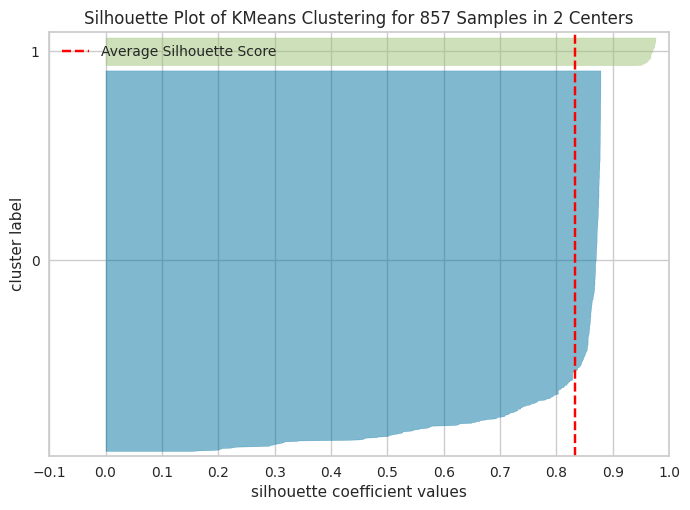



=== Silhouette plot for 3 Clusters ===


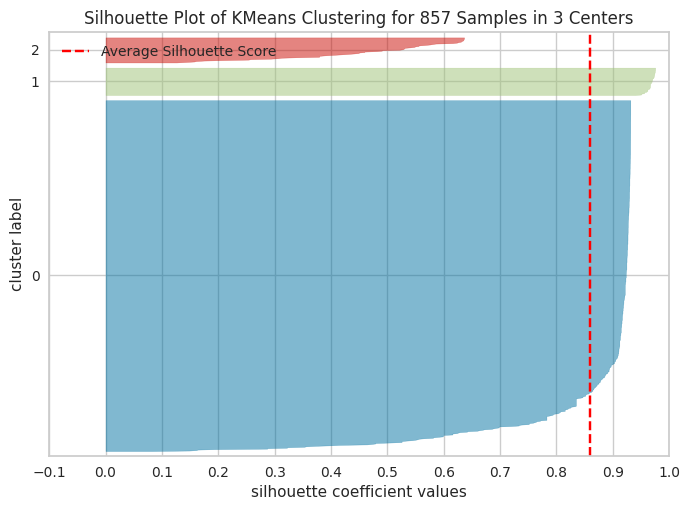



=== Silhouette plot for 4 Clusters ===


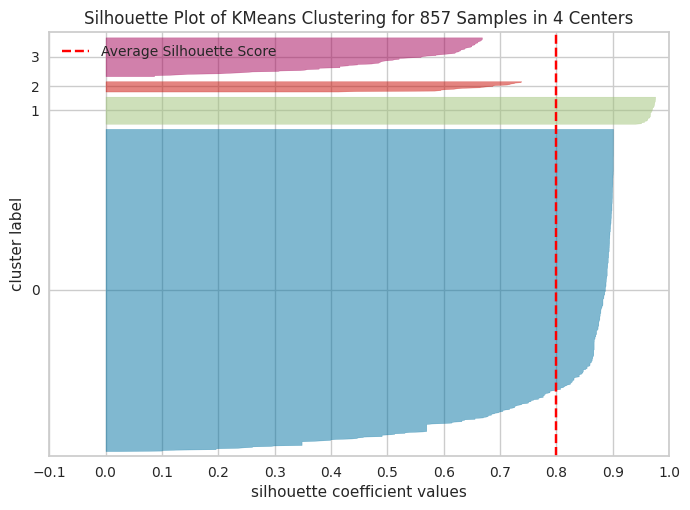



=== Silhouette plot for 5 Clusters ===


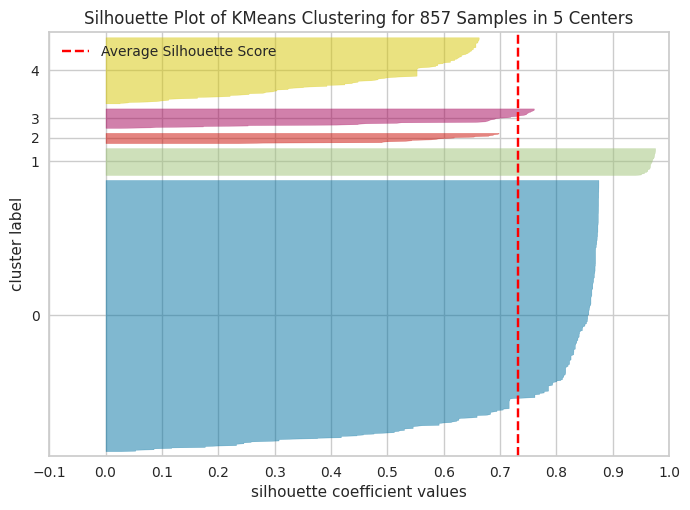

In [16]:
from yellowbrick.cluster import SilhouetteVisualizer

# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


In [17]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.5, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=1, random_state=0)),

        # we update n_clusters to 2
        ("model", KMeans(n_clusters=2, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=1, random_state=0)),
                ('model', KMeans(n_clusters=2, random_state=0))])

## Fit Cluster Pipeline

Quick recap of our data for training cluster pipeline

In [18]:
X = df.copy()
print(X.shape)
X.head(3)

(857, 17)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317


Fit Cluster pipeline

In [19]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['Wing_Span', 'Length',
                                                     'Height', 'TP_mods', 'AUW',
                                                     'MEW', 'FW', 'Vmax',
                                                     'Vcruise', 'Vstall',
                                                     'Range', 'Hmax', 'ROC',
                                                     'Vlo', 'Slo', 'Vl',
                                                     'Sl'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_component

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [20]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(857, 18)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl,Clusters
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075,0
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824,0
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317,0


* Clusters frequencies 
   Clusters
0      0.93
1      0.07 




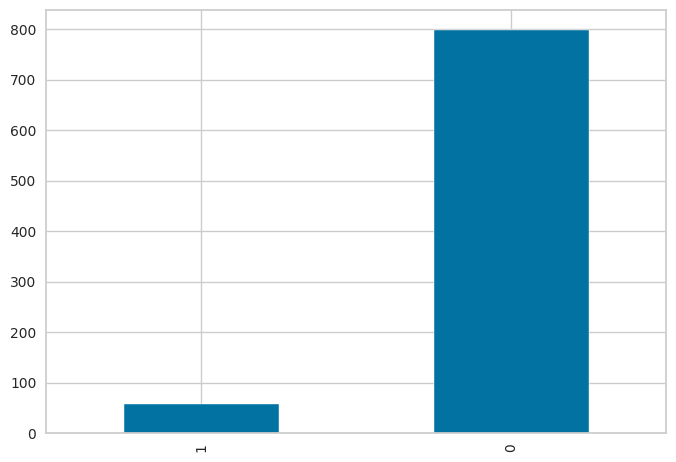

In [21]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

In [22]:
print(df_analysis.shape)


(857, 2)


Why is the y=df_analysis[:, 1] set to the second column???????????????????

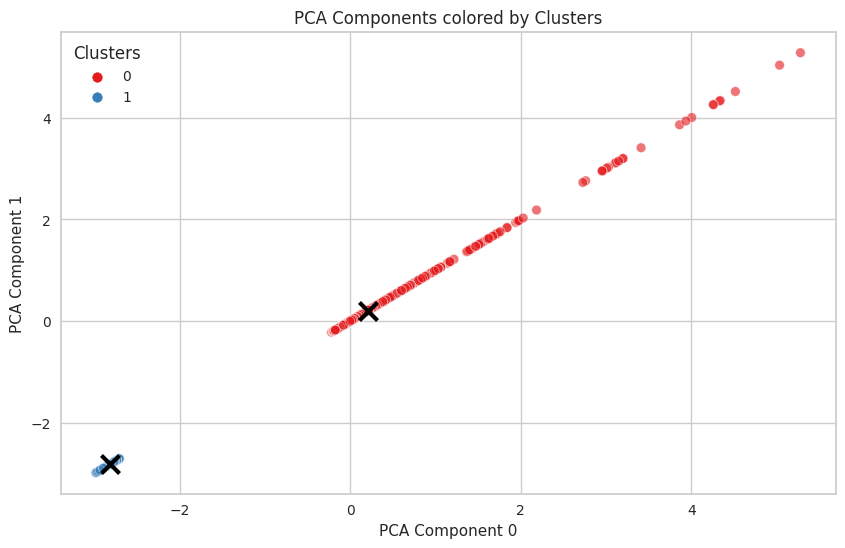

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 0],  # Original code is: y=df_analysis[:, 1] but that gives an error since it tries to acces the second column of a one column df
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 0],  # Same here! Original code: cluster_centers_[:, 0]
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()


We save the cluster predictions from this pipeline to use in the future. We will get back to that in a later stage.

In [24]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0      0
1      0
2      0
3      0
4      0
      ..
852    0
853    0
854    0
855    0
856    0
Name: Clusters, Length: 857, dtype: int32

## Fit a classifier, where the target is cluster predictions and features remaining variables

We copy `X` to a DataFrame `df_clf`

In [25]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(857, 18)


,Wing_Span,Length,Height,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,ROC,Vlo,Slo,Vl,Sl,Clusters
0,37.416667,25.250000,10.250000,No,2050.0,1180.0,241.2,104.0,91.0,46.0,370.0,13000.0,450.0,900.0,391.970247,1300.0,257.745075,0
1,36.083333,20.583333,8.750000,No,1350.0,820.0,100.5,89.0,83.0,44.0,190.0,12300.0,600.0,720.0,26.247647,800.0,225.324824,0
2,35.000000,21.416667,8.583333,No,1300.0,810.0,127.3,90.0,78.0,37.0,210.0,16000.0,650.0,475.0,363.139711,850.0,585.751317,0


Split Train and Test sets

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(685, 17) (172, 17)


Create classifier pipeline steps

In [27]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.ensemble import GradientBoostingClassifier


def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['TP_mods'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

Fit the classifier to the training data

In [28]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['TP_mods'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Wing_Span', 'Length',
                                                     'Height', 'TP_mods', 'AUW',
                                                     'MEW', 'FW', 'Vmax',
                                                     'Vcruise', 'Vstall',
                                                     'Range', 'Hmax', 'ROC',
                                                     'Vlo', 'Slo', 'Vl',
                                                     'Sl'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
    

## Evaluate classifier performance on Train and Test Sets

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00        48

    accuracy                           1.00       685
   macro avg       1.00      1.00      1.00       685
weighted avg       1.00      1.00      1.00       685



In [30]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       1.00      1.00      1.00        11

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172



## Assess the most important Features that define a cluster

* These are the 1 most important features in descending order. The model was trained on them: 
['TP_mods'] 



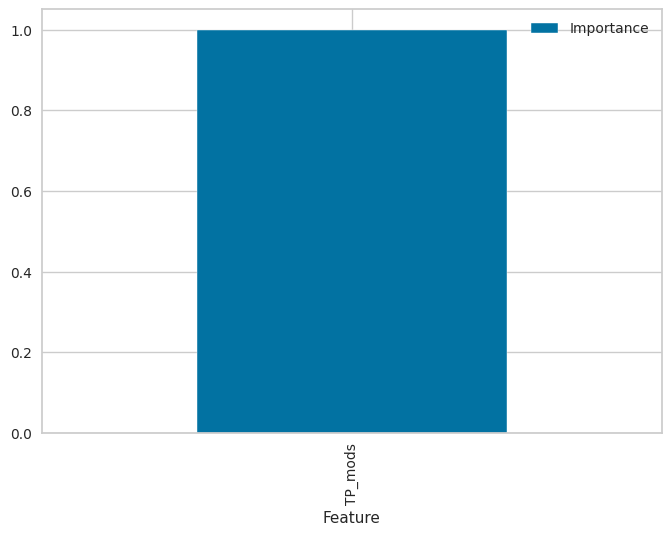

In [31]:
# after data cleaning and feature engineering, the feature space changes

# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


We will store the best_features to use at a later stage.

In [32]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['TP_mods']

## Cluster Analysis

Load function that plots a table with description for all Clusters

In [33]:

def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription


Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

In [34]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')


Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.


In [35]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(857, 2)


,TP_mods,Clusters
0,No,0
1,No,0
2,No,0


We want also to analyse distribution of Multi Engine and Engine Types.

In [36]:
df_multi_engine = pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv").filter(['Multi_Engine'])
df_multi_engine['Multi_Engine'] = df_multi_engine['Multi_Engine'].astype('object')
df_multi_engine.head(3)

,Multi_Engine
0,False
1,False
2,False


In [37]:
df_engine_type = pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv").filter(['Engine_Type'])
df_engine_type['Engine_Type'] = df_engine_type['Engine_Type'].astype('object')
df_engine_type.head(3)

,Engine_Type
0,0
1,0
2,0


### Cluster profile based on the best features

For Engine Type

In [38]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_multi_engine], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_2346/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_2346/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


,TP_mods,Multi_Engine
Cluster,,
0,'No': 100%,"'False': 54% , 'True': 46%"
1,'Yes': 100%,"'True': 68% , 'False': 32%"


...and for Engine Type

In [39]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_engine_type], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_2346/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_2346/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


,TP_mods,Engine_Type
Cluster,,
0,'No': 100%,"'0': 69% , '2': 19% , '1': 12%"
1,'Yes': 100%,"'0': 97% , '1': 3%"


### Clusters distribution across Multi Engine and Engine Type distributions & Relative Percentage of Multi Engine and Engine Type in each cluster

In [40]:
df_cluster_vs_multi_engine=  df_multi_engine.copy()
df_cluster_vs_multi_engine['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_multi_engine, target='Multi_Engine')

Clusters distribution across Multi_Engine levels


Relative Percentage (%) of Multi_Engine in each cluster


In [41]:
df_cluster_vs_engine_type=  df_engine_type.copy()
df_cluster_vs_engine_type['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_engine_type, target='Engine_Type')

Clusters distribution across Engine_Type levels


Relative Percentage (%) of Engine_Type in each cluster


# Fit New Cluster Pipeline with most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [42]:
best_features_pipeline_all_variables

['TP_mods']

## Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will
1. Conduct a elbow method and silhouette analysis and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"

If we are happy to say **yes** for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!
* The **gain** is that in real-time (which is the major purpose of Machine Learning) you will need fewer variables for predicting clusters for your prospects.

## Subset data with the most relevant variables

In [43]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

,TP_mods
0,No
1,No
2,No


## Rewrite Cluster Pipeline

# CHECK THE ENCODER HERE!!!!

In [44]:
def PipelineCluster():
    pipeline_base = Pipeline([

        # WE DO NOT NEED THIS ANYMORE SINCE THE CHOOSEN FEATURE ARE NOT CATEGORICAL!!!!!!!: 'Hmax_(One)', 'AUW'
        # we update the pipeline, considering only the most important variables from the previous pipeline
        #("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                             variables=['Engine_Type', 'Multi_Engine', 'TP_mods'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # No PCA step needed, since we know which features to consider

        ("model", KMeans(n_clusters=2, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=2, random_state=0))])

## Apply Elbow Method and Silhouette analysis

In [45]:
print(df_reduced.columns)


Index(['TP_mods'], dtype='object')


In [46]:
print(df_reduced)

    TP_mods
0        No
1        No
2        No
3        No
4        No
..      ...
852      No
853      No
854      No
855      No
856      No

[857 rows x 1 columns]


In [48]:
# Convert 'Yes' to 1 and 'No' to 0 for specific columns
df_reduced['TP_mods'] = df_reduced['TP_mods'].map({'Yes': 1, 'No': 0})

# Inspect result!
print(df_reduced.head())


   TP_mods
0        0
1        0
2        0
3        0
4        0


# FIX THIS!!!! It is the TP mods that cant be converted to a float

In [49]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

(857, 1) 
 <class 'numpy.ndarray'>


Elbow Analysis

In [51]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

/workspace/.pip-modules/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.

/workspace/.pip-modules/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:93: RuntimeWarning:

Mean of empty slice.

/workspace/.pip-modules/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning:

invalid value encountered in true_divide



ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 5

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


## Fit New Cluster Pipeline

We set X as our training set for the cluster. It is a copy of df_reduced

In [ ]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

Fit Cluster pipeline

# Same thing with string to float!!!!!!

In [ ]:
# Convert 'Yes' to 1 and 'No' to 0 for specific columns
df_reduced['TP_mods'] = df_reduced['TP_mods'].map({'Yes': 1, 'No': 0})

# Inspect result!
print(df_reduced.head())


In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

# Fix here as well!!!!!!!!!!!!!!

In [ ]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

In [ ]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Compare current cluster predictions to previous cluster predictions

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" to the previous cluster.

These are the predictions from the **previous** cluster pipeline - trained with all variables 

In [ ]:
cluster_predictions_with_all_variables

# CHECK THIS!!!!

And these are the predictions from **current** cluster pipeline (trained with `['Hmax_(One)', 'AUW']`)

In [ ]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

## Fit a classifier, where the target is cluster predictions and features remaining variables

In [ ]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

Split Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


Rewrite pipeline to explain clusters

# CHECK THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        
        # NO NEED FOR THIS ANYMORE!!!!!!!!!!!!!!!!!!!!!!!
        #("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                             variables=['OnlineBackup', 'PhoneService'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # we don't consider feature selection step, since we know which features to consider

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


## Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [ ]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

## Evaluate classifier performance on Train and Test Sets

In [ ]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

In [ ]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

## Assess Most Important Features

In [ ]:
# since we don't have feature selection step in this pipeline, best_features is Xtrain columns
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Cluster Analysis

Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.


In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

We want also to analyse Multi Engine and Engine Type distributions

In [ ]:
df_cluster_vs_multi_engine=  df_multi_engine.copy()
df_cluster_vs_multi_engine['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_multi_engine, target='Multi_Engine')

In [ ]:
df_cluster_vs_engine_type=  df_engine_type.copy()
df_cluster_vs_engine_type['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_engine_type, target='Engine_Type')

### Cluster profile on most important features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_multi_engine], axis=1), decimal_points=0)
clusters_profile

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_engine_type], axis=1), decimal_points=0)
clusters_profile

### Clusters distribution across Multi Engine and Engine Type distributions & Relative Percentage of Multi Engine and Engine Type in each cluster

In [ ]:
df_cluster_vs_multi_engine=  df_multi_engine.copy()
df_cluster_vs_multi_engine['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_multi_engine, target='Multi_Engine')

In [ ]:
df_cluster_vs_engine_type=  df_engine_type.copy()
df_cluster_vs_engine_type['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_engine_type, target='Engine_Type')

## Which pipeline should I deploy?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Conduct an elbow method and silhouette analysis and check if the same number of clusters is suggested.
2. Fit a new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline.
3. Fit a classifier to explain cluster and check if performance on Train and Test sets is similar to the previous pipeline.
4. Check if the most important features for the classifier are the same from the previous pipeline.
5. Compare if the cluster profile from both pipelines is "equivalent".


In [ ]:
pipeline_cluster

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [76]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


## Cluster pipeline

In [ ]:
pipeline_cluster

In [ ]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

## Train Set

In [ ]:
print(df_reduced.shape)
df_reduced.head(3)

In [80]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [ ]:
clusters_profile

In [84]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

In [ ]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Good job, clear the cell outputs, run git commands to add, commit and push files to the repo. Next, we will move on to create our dashboard!